In [1]:
from transformers import BertTokenizer
import torch, json, os, re, random, sys
from tqdm import tqdm
sys.path.append("../scripts/")
from pprint import pprint
from vlc import VLCTransformer as vlc
from torchvision import transforms
from PIL import Image
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from pprint import pprint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/yingshan/clevr_control/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = BertTokenizer.from_pretrained(
    "bert-base-uncased", 
    do_lower_case=True
)
tokenizer.pad_token_id = 102

In [3]:
model = vlc(
    vlc_version = "large",
    hidden_size = 1024
)
model.cuda()
state_dict = torch.load("../scripts/probing/vlc_L16.ckpt", map_location=device)["state_dict"]
model.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['mlm_score.bias', 'mlm_score.transform.dense.weight', 'mlm_score.transform.dense.bias', 'mlm_score.transform.LayerNorm.weight', 'mlm_score.transform.LayerNorm.bias', 'mlm_score.decoder.weight', 'itm_score.fc.weight', 'itm_score.fc.bias', 'text_embeddings.position_ids'])

In [4]:
texts = ["a cat is on top of a car", "a cat is at the bottom of a car"]
encoded_text = tokenizer.batch_encode_plus(
    texts,
    padding=True,
    truncation=True,
    return_tensors="pt",
    return_special_tokens_mask=True,
)
encoded_text.input_ids, encoded_text.attention_mask


(tensor([[ 101, 1037, 4937, 2003, 2006, 2327, 1997, 1037, 2482,  102,  102],
         [ 101, 1037, 4937, 2003, 2012, 1996, 3953, 1997, 1037, 2482,  102]]),
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]))

In [5]:
input_ids = encoded_text.input_ids.to(device)
attention_masks = encoded_text.attention_mask.to(device)

outputs = model.forward_language_encoder(
    input_ids,
    attention_masks,
)

In [6]:
outputs.size()

torch.Size([2, 11, 1024])

In [7]:
coco = json.load(open("../data/coco/annotations/dataset_coco.json", "r"))['images']
print("#images: ",len(coco))
all_sentences = []
for d in coco:
    for s in d['sentences']:
        all_sentences.append((s['raw'], d['filename']))
print("#sentences: ", len(all_sentences))
relations = [
    "on top of",
    "bottom of",
    " under ",
    " beneath ",
    "in front of",
    " behind ",
    "on the left",
    "on the right",
    "left of",
    "right of",
]
r2s = defaultdict(list)
for s in all_sentences:
    for r in relations:
        if r in s[0]:
            r2s[r].append(s)
for k in r2s:
    print(k, len(r2s[k]))

#images:  123287
#sentences:  616767
in front of 17939
 beneath  492
on top of 16372
 under  6720
 behind  6580
bottom of 323
on the left 42
left of 25
on the right 52
right of 16


A picture of a man with suit, tie and serious face on the left side and wild hair, a smile, and a T-shirt on the right side.


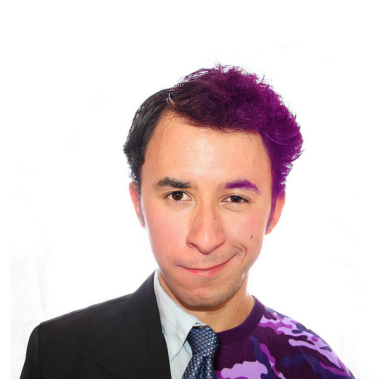

In [8]:
s, imfile = random.choice(r2s['on the right'])
path = "../data/coco/images/{}/{}".format(imfile.split("_")[1], imfile)
im = Image.open(path)
print(s)
plt.axis("off")
plt.imshow(im)

In [9]:
trs = transforms.Compose([
        transforms.Resize((384, 384), interpolation=Image.BICUBIC), 
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def preproc_image(path):
    image = Image.open(path).convert("RGB")
    return trs(image).unsqueeze(0)


In [11]:
texts = [s]
encoded_text = tokenizer.batch_encode_plus(
    texts,
    padding=True,
    truncation=True,
    return_tensors="pt",
    return_special_tokens_mask=True,
)

input_ids = encoded_text.input_ids.to(device)
attention_masks = encoded_text.attention_mask.to(device)
img = preproc_image(path).to(device)

outputs = model.forward_vl_encoder(
    input_ids, 
    attention_masks, 
    img
)

outputs[1].size()

torch.Size([1, 577, 1024])

In [12]:
outputs[0].size()

torch.Size([1, 35, 1024])